# Data Science Homework 4
Try different imbalanced classification datasets using $k$-fold cross validation and various classification methods.
TODO List:
- Make sure we can open all the data as either DataFrame or nparray
- Handle categorical data (tokenize, one-hot encoding, ....)
- Split each dataset into training and testing dataset.
- Perform any necessary sampling, imputaiton, encoding techniques depending on dataset
- Perform 5-fold cross-validation to select datasets.

In [28]:
import os
import imblearn
import numpy as np
import pandas as pd
import xgboost
import lightgbm
import neuralnet # My simple nn
import sklearn.svm as svm
import sklearn.metrics as metrics
import category_encoders as ce # sklearn library
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split,  StratifiedKFold

from sklearn import preprocessing

DATA_DIR = './data'
files = os.listdir(DATA_DIR)
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')

special_delims = { 'arcene_train.data': ' '}
no_headers = ['covtype.data', 'arcene_train.data']

numMethods = ['clip',
              'standard',
              'minmax',
              'bin',
              'rank'
            ]
ceMethods = ['onehot',
              'label',
              'feature',
              'target',
              'leaveoneout',
              'frequency'
             ]
modelNames = ['forest',
             'xgboost',
             'lightgbm',
             'mlp',
             'svm'
            ]

## Load datasets
Some datasets are in csv format, others have just the data. First convert to `DataFrame`s to allow for numeric, categorical values.

In [20]:

def load(name, header=True):
    sep = special_delims[name] if name in special_delims else ','
    name = os.path.join(DATA_DIR, name)
    if header:
        df = pd.read_csv(name, sep=sep)
    else:
        df = pd.read_csv(name, header=None, sep=sep)
    
    # Move target column to last
    if  'WineQT.csv' in name:
        cols = list(df.columns)
        x, y = cols.index('quality'), cols.index('Id')
        cols[x], cols[y] = cols[y], cols[x]
        df = df[cols]
    return df

## Encode Categorical Values

In [3]:
def encode_per_column(data, encoder):
    for column in data.columns:
        data.loc[:, column] = encoder.fit_transform(data.loc[:, column])
    return data
        
def encode_categorical(data:pd.DataFrame, method='ordinal', y=None):
    if method == 'ordinal':
        encoder = ce.OrdinalEncoder()
    elif method == 'onehot':
        encoder = ce.OneHotEncoder()
    elif method == 'label':
        encoder = preprocessing.LabelEncoder()
        return encode_per_column(data,encoder)
    elif method == 'feature':
        encoder = FeatureHasher(n_features=10, input_type='string')
        encoder.transform(data.type)
    elif method == 'target':
        encoder = ce.target_encoder.TargetEncoder()
        
        return encoder.fit_transform(data.iloc[:, :-1], y)
    elif method == 'leaveoneout':
        y = data.iloc[:,-1]
        encoder = ce.LeaveOneOutEncoder()
        return encoder.fit_transform(data.iloc[:,:-1], y)
    elif method == 'frequency':
        encoder = ce.CountEncoder()
    return encoder.fit_transform(data)

def scale_features(data:pd.DataFrame, method='standard') -> pd.DataFrame:
    if method == 'standard':
        scaler = preprocessing.StandardScaler()
    elif method == 'minmax':
        scaler = preprocessing.MinMaxScaler()
    elif method == 'clip':
        for column in data.columns:
            p01 = data[column].quantile(.01)
            p99 = data[column].quantile(.99)
            data[column].clip(p01, p99)
        return data
    elif method == 'bin':
        for column in data.columns:
            data.loc[:, column] = pd.cut(data.loc[:, column], 5, labels=False, duplicates='drop')
        return data
    elif method == 'rank':
        for column in data.columns:
            data.loc[:, column] = data[column].rank()
        return data
    
    return scaler.fit_transform(data)

## Train model:
The evalutation should be fixed on 5-fold cross validation, choose from `RandomForest`, `GBDT`, `XGBoost`,`LightBGM`, `CatBoost`, `KNN`, `Logistic Regression`,`MLP`, `SVM`.

Train a new model every iteration of the cross-validation.

In [30]:

def get_model(method):
    if method == 'xgboost':
        model = xgboost.XGBClassifier(5)
    elif method == 'knn':
        model = KNeighborsClassifier()
    elif method == 'forest':
        model = RandomForestClassifier(10)
    elif method == 'lightgbm':
        model = lgb
    elif method == 'mlp':
        model = neuralnet.tabularNet()
    elif method == 'svm':
        model = svm.SVC()
    else:
        print(f'{method} not supported.')
        model = None
    return model

def get_metric(method):
    if method == 'acc':
        met = metrics.accuracy_score
    elif method == 'auc':
        met = metrics.auc
    elif method == 'roc_auc':
        met = metrics.roc_auc_score
    elif method == 'f1':
        met = metrics.f1_score
    
    return met

def train(x, y, method='xgboost', metric='acc'):
    # Perform K-Fold cross validation
    metric = get_metric(metric)
    n_items = x.shape[0]
    kf = StratifiedKFold( n_splits=5, shuffle=True)
    
    mean_score = 0 
    for i, (train_index, test_index) in enumerate(kf.split(x, y)):
        model = get_model(method)
        x_train, x_test = x.iloc[train_index,: ], x.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # 
        try:
            if y_test.min().item()  != 0 and method == 'xgboost':
                y_train -= y_train.min().item() # Class labels should be zero-based
        except ValueError:
            pass
            
        model.fit(x_train, y_train)
        
        # Evaluate
        preds = model.predict(x_test)
        score = metric(y_test, preds)
        mean_score += score
        #print(f'\t{mean_score}')
        
    mean_score /= (i+1)
    #print(f'Mean score over validation: {mean_score} using {method}')

    return mean_score
        

    # Under sampling
## P1: How does feature scaling (e.g. performing normalization) affect performance?
With standardization we apply the formula
$$x' = \frac{x - \mu}{\sigma}$$
so that we have 0 mean in the training data.

For One-hot Encoding we should not use this with tree-based models. For these models we can use label encoding, feature-hashing.
We should first encode the categorical values, then train the models on all our datasets both with feature scaling and without.

In [ ]:
for file in files:
    
    df = load(file, False if file in no_headers else True)
    # Encode categorical columns
    cats = df.select_dtypes(include=['object'])
    df[cats.columns] = encode_categorical(cats)
    
    control = df.copy(deep=True) # Compare with standardized dataset

    df, labels = df.iloc[:, :-1], df.iloc[:, -1]
    control, c_labels = control.iloc[:, :-1], control.iloc[:, -1]
    
    # Feature scaling
    df = pd.DataFrame(scale_features(df))
    
    # Train model
    print(f'Training on {file}')
    score = train(df, labels, method='knn', metric='acc')
    print(f'train: {file}: avg: {score}')
   
    score = train(control, c_labels, method='knn', metric='acc')
    print(f'test: {file}: avg: {score}')
    print('\n')
    # The performance is mostly the same across models

Training on covtype.data


## P2 When using tree-based algorithms, will usng one-hot encoding for categorical features generate worse performance than using label encoding? Why?
One-hot encoding transforms inputs with a range of $(1,\dots,n)$. This method generates extra columns and usually results in a sparse matrix.

Label Encoding adds replaces each unique class name with an integer.

In [38]:
for file in files:
    df = load(file, False if file in no_headers else True)
    target_column = df.columns[-1]
    label = df.copy(deep=True) # Use label encoding
    
    cats = label.select_dtypes(include=['object'])

    # Ignore files w/ no categorical data, otherw encoder error
    if cats.empty:
        print(f'No categorical in {file}\n')
        continue
        
    one_hot = pd.get_dummies(df)
    cats = label.select_dtypes(include=['object'])

    # Apply Label Encoder to each column

    label.loc[:, cats.columns] = encode_categorical(label.loc[:, cats.columns], method='label')
    
    # If target column is not categorical, labels will only be one column
    if df.dtypes[target_column] == object:
        n_unique = df[target_column].unique().shape[0]
    else:
        n_unique = 1
    
    x_ohe, y_ohe = one_hot.iloc[:,:-n_unique], one_hot.iloc[:,-n_unique:]
    x_label, y_label = label.iloc[:,:-1], label.iloc[:,-1]
    
    #print(f'{file}: xcols: {len(x_label)} ycols: {len(y_label)}')
    #print(one_hot)
    print(f'Training on {file}')
    score = train(x_ohe, y_ohe, method='forest', metric='acc')
    print(f'Onehot avg: {score}')
    
    score = train(x_label, y_label, method='forest', metric='acc')
    print(f'label avg: {score}')
    print('\n')
    ## There is a slight difference in performance (label encoder usually better by a bit)

Training on abalone.data
Onehot avg: 1.0


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using rav

label avg: 0.22695814113399995


No categorical in arcene_train.data

Training on biodeg.csv
Onehot avg: 0.8274881516587677
label avg: 0.8606635071090049


No categorical in covtype.data

Training on dataset
Onehot avg: 0.9727047522750253


C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
C:\Users\Andres Ponce\AppData\Local\Temp\ipykernel_2264\2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using rav

label avg: 0.8798550724637682


No categorical in eeg_eye_state.arff

Training on heart_2020_cleaned.csv
Onehot avg: 0.8703513188136149
label avg: 0.8889694960834286


No categorical in HTRU_2.csv

Training on income_evaluation.csv
Onehot avg: 0.8233776446351296
label avg: 0.849052608259195


No categorical in phpAmSP4g.arff

Training on Raisin_Dataset.arff
Onehot avg: 0.8355555555555556
label avg: 0.8477777777777777


No categorical in spambase.data

No categorical in UCI_Credit_Card.csv

Training on WA_Fn-UseC_-Telco-Customer-Churn.csv
Onehot avg: 0.7492533792502742
label avg: 0.7819127443706045


No categorical in WineQT.csv



## P3
Will feature binning provide performance improvement? When is binning useful (which models or which kinds of datasets)?

Loop through each column in the dataframe and bin individually.
We use LabelEncoder for categorical features on both DataFrames.

In [ ]:
for file in files:
    df = load(file, False if file in no_headers else True)
    binned = df.copy(deep=True)
    # TODO: fix arcene random space unable to parse
    if file == 'arcene_train.data':
        continue
    # Bin each column individually, use LabelEncoder for categorical
    for column in binned.columns:
        if (binned[column].dtype.name == 'int64'
           or binned[column].dtype.name == 'float64'):
            #n_unique = binned[column].unique() 
            binned[column]= pd.cut(binned[column], 5, labels=False, duplicates='drop')
            #binned[column].fillna(0, inplace=True)

            if binned[column].isnull().values.any():
                binned[colum] = 0
        #elif check if column is categorical
        elif binned[column].dtype.name == 'object':
            binned[column] = encode_categorical(binned[column], method='label')
            df[column] = encode_categorical(df[column], method='ordinal')

    # Train
    x_bin, y_bin = binned.iloc[:, :-1], binned.iloc[:, -1]
    x_label, y_label = df.iloc[:, :-1], df.iloc[:, -1]
    
    print(f'Training on {file}')
    score = train(x_bin, y_bin, method='forest', metric='acc')
    print(f'train: {file}: avg: {score}')
    
    score = train(x_label, y_label, method='forest', metric='acc')
    print(f'test: {file}: avg: {score}')
    print('\n')

## P4
Compare the performance of 6 different categorical feature encoding methods based on Random Forest, XGBoost LightGBM, MLP, SVM. Which of the 6 encoding methods is better?
TODO: Finish implementing neural network (missing dataloader)

Models to test: 
1. One hot encoding
2. Label Encoding
3. Feature Hasing
4. Frequency Encoding
5. Target Encoding
6. Leave One Out Encoding

In [48]:
for file in files:
    print(f'Checking {file}')
    df = load(file, header = False if file in no_headers else True)
    cats = df.select_dtypes(include=['object'])
    for method in ceMethods:
        # Encode features
        encoded = df.copy()
        
        try:
            encode_categorical(encoded, method=method)
        except:
            continue
            
        for modelName in modelNames:
            # Number of class columns, necessary for OHE
            labelIndex = len(df.iloc[:,-1].unique()) if method == 'onehot' else 1
            enc_train, enc_test = encoded.iloc[:,:-labelIndex], encoded.iloc[:,-labelIndex:]
            score = train(enc_train, enc_test, modelName)
            print(f'\t({method}, {modelName}): {score}')
            

Checking covtype.data


KeyboardInterrupt: 

## P5
Which combinations of numerical and categorical feature transformation methods generally lead to better results?

Here we can test the different numerical and categorical methods on each dataset.

In [54]:

for file in files:
    df = load(file, False if file in no_headers else True)
    print(f'Checking: {file}')
    # Encode only numerical columns
    for numMethod in numMethods:
        numcats = df.select_dtypes(include=['float64', 'int64'])
        scale_features(df[numcats.columns], method=numMethod)
        
        # Encode only categorical columns
        for ceMethod in ceMethods:
            cats = df.select_dtypes(include=['object'])
            encode_categorical(df[cats.columns], method=ceMethod)
            x, y = df.iloc[:, :-1], df.iloc[:, -1]
            score = train(x, y, method='forest')
            print(f'\tNumerical: {numMethod}, Categorical: {ceMethod}, Acc: {score}')
            

Checking: covtype.data
clip
	clip, label, 0.9424676226708968
standard


KeyboardInterrupt: 

## P6
If the number of possible categorical values of a feature is high, which encoding method among target encoding, one-hot encoding, and label encoding will have better performance? Why?

Go through each file, test each encoding method, and measure the $n$ datasets with most unique values.

In [19]:
enc_methods = [#'target',
               'onehot',
               'label',
              ]

for file in files:
    df = load(file, header=False if file in no_headers else True)
    print(f'Training on {file}')
    for enc_method in enc_methods:
        df_copy = df.copy()

        # OHE produces this many label columns
        n_labels = df_copy.iloc[:, -1].nunique() if enc_method == 'onehot' else 1
        
        # Encode df using method
        cats = df_copy.select_dtypes(include=['object'])
        if cats.empty:
            print(f'{file} has not categorical')
            continue
            
        max_uniques = max([len(df_copy[col].unique()) for col in cats.columns])
        if enc_method == 'onehot':
            print(n_labels)
            df_copy = pd.get_dummies(df_copy)
        else:
            df_copy[cats.columns] = encode_categorical(df_copy[cats.columns], method=enc_method, y=df_copy.iloc[:,-1])
            
        x, y = df_copy.iloc[:,:-n_labels], df_copy.iloc[:, -n_labels:]

        # Train model
        score = train(x, y, method='forest')
        print(f'\tmethod: {enc_method},  max unique categories: {max_uniques} score: {score}')
        


Training on covtype.data
covtype.data has not categorical
covtype.data has not categorical
Training on dataset
2
      family_status_Married  family_status_Unmarried
0                         0                        0
1                         0                        0
2                         0                        0
3                         0                        1
4                         1                        0
...                     ...                      ...
1718                      0                        0
1719                      0                        0
1720                      0                        0
1721                      0                        0
1722                      0                        0

[1723 rows x 2 columns]
	method: onehot,  max unique categories: 22 score: 0.9262824401752612
      bad_client_target
0                     0
1                     0
2                     0
3                     0
4                     0
...         

/tmp/ipykernel_38713/3221905460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])
/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

	method: onehot,  max unique categories: 2 score: 0.8151658767772512
      class
0         1
1         1
2         1
3         1
4         1
...     ...
1050      0
1051      0
1052      0
1053      0
1054      0

[1055 rows x 1 columns]
	method: label,  max unique categories: 2 score: 0.8597156398104266
Training on eeg_eye_state.arff
eeg_eye_state.arff has not categorical
eeg_eye_state.arff has not categorical


/tmp/ipykernel_38713/3221905460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])
/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

Training on heart_2020_cleaned.csv
2
        SkinCancer_No  SkinCancer_Yes
0                   0               1
1                   1               0
2                   1               0
3                   0               1
4                   1               0
...               ...             ...
319790              1               0
319791              1               0
319792              1               0
319793              1               0
319794              1               0

[319795 rows x 2 columns]
	method: onehot,  max unique categories: 13 score: 0.8701949686517926


/tmp/ipykernel_38713/3221905460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, column] = encoder.fit_transform(data.loc[:, column])


        SkinCancer
0                1
1                0
2                0
3                1
4                0
...            ...
319790           0
319791           0
319792           0
319793           0
319794           0

[319795 rows x 1 columns]


/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)
/tmp/ipykernel_38713/2851209381.py:49: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


KeyboardInterrupt: 

## Plot class imbalance

covtype.data


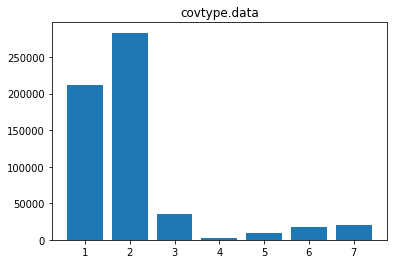

dataset


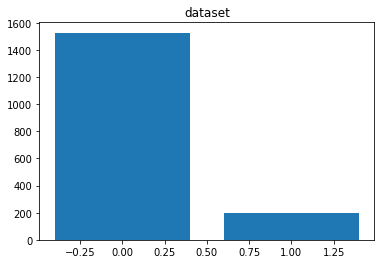

biodeg.csv


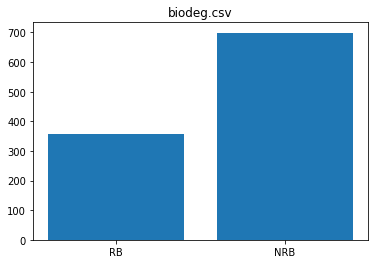

eeg_eye_state.arff


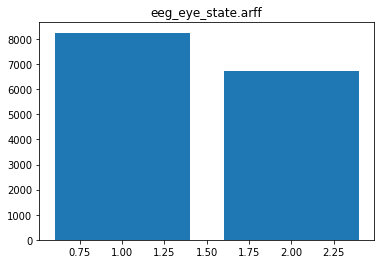

heart_2020_cleaned.csv


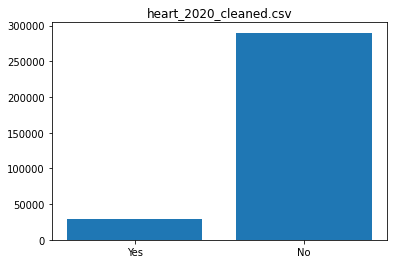

phpAmSP4g.arff


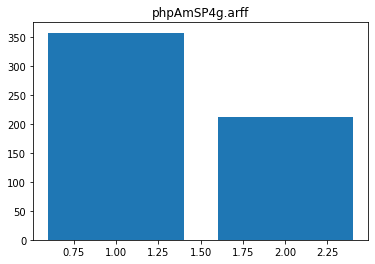

WA_Fn-UseC_-Telco-Customer-Churn.csv


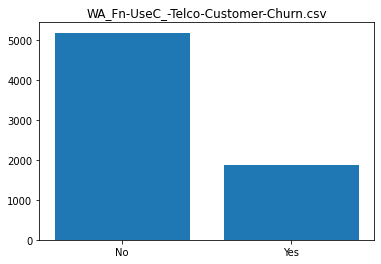

WineQT.csv


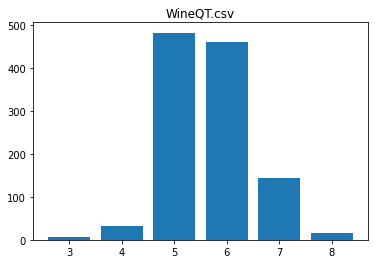

HTRU_2.csv


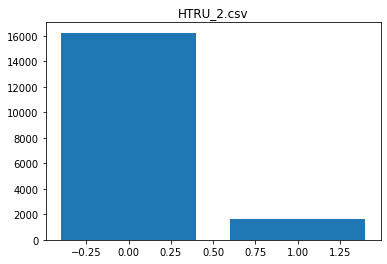

spambase.data


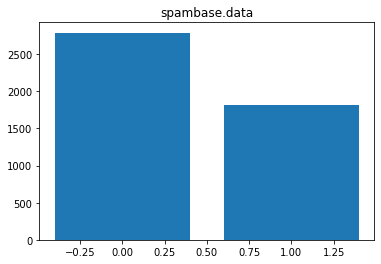

Raisin_Dataset.arff


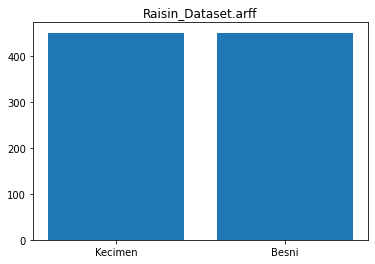

UCI_Credit_Card.csv


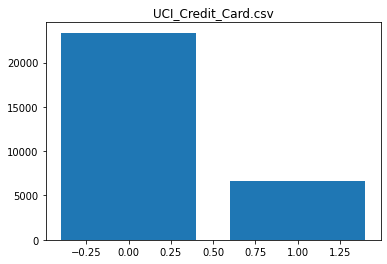

income_evaluation.csv


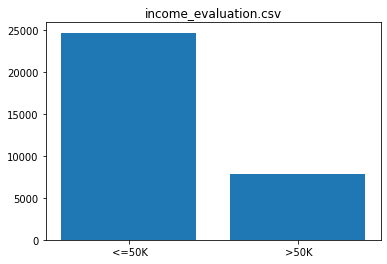

abalone.data


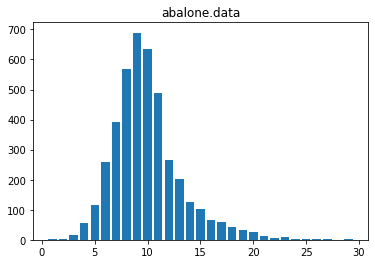

arcene_train.data


EmptyDataError: No columns to parse from file

In [25]:
def plot_imbalance(data:pd.DataFrame, title:str):
    plt.title(title)
    target = data.iloc[:, -1]
    names, counts = [],[]
    for unique in target.unique():
        count = target[target == unique].count()
        counts.append(count)
        names.append(unique)
    plt.bar(names, counts)
    plt.show()
    
for file in files:
    print(f'{file}')
    df = load(file, False if file in no_headers else True)
    plot_imbalance(df, file)

## Imbalanced data samplers


In [7]:
def get_imb_sampler(method:str):
    if method == 'nearmiss':
        return imblearn.under_sampling.NearMiss()
    
def get_imb_sample(x:pd.DataFrame, y:pd.Series, s_method:str='nearmiss'):
    sampler = get_imb_sampler(us_method)
    return sampler.fit_resample(x, y)

def train_imb(x:pd.DataFrame, y:pd.DataFrame, model='ovr', metric='prc'): 
    # TODO: Use OVR classifier to 
    

## P7
Compare the classification performance of "doing nothing", 7 undersampling,4 oversampling, and 2 ensemble based methods in presence of class imbalance. Which method works generally best and the worst? Why?

Since we are interested in measuring our performance on the minority class, we use precision-recall curve.
First we get the training and testing data, and apply the sampling method on only the training set.

In [8]:
under_sampling_methods = ['nearmiss',
                          'clustercentroids',
                          'condensednn',
                          'editednn',
                          'neighbourhoodcleaning',
                          'tomeklinks',
                          'onesidedselection'
                         ]
for file in files:
    df = load(file, False if file in no_headers else True)
    # Encode df
    df = encode_categorical(df)
    
    # Split into testing and training set
    x, y = df.iloc[:, :-1], df.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)
    
    # Sample 
    for us_method in under_sampling_methods:
        x_sample, y_sample = get_imb_sample(x_train, y_train, s_method=us_method)
        
        score = train(x_sample, y_sample, model='forest', metric='
        print(x_train.shape, x_sample.shape)
        break
    break

(406708, 54) (13223, 54)
